# Application Example: Using Index Map Relationship to Relate Two Images

The following example illustrates the use of index map relationships to define relationships between two images. We here use an example a mass spectrometry imaging dataset of the left coronal hemisphere of a mouse brain in relationship to a larger gray-scale image derived from the MSI dataset.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.misc
import numpy as np
from tempfile import NamedTemporaryFile
import h5py
import sys
import urllib
import os 
from sklearn import decomposition
from brain.dataformat.base import RelationshipAttribute
from __future__ import unicode_literals
save_images = True

# Preparing the example dataset
## Download example dataset from: openmsi.nersc.gov

We here use a mass spectrometry imaging dataset available via OpenMSI. We thank the contributors of the dataset and the OpenMSI team for sharing the dataset:

* **Sample:** a mouse brain: left coronal hemisphere
* **Instrument:** AbSciex 5800
* **Desorption/Ionization Method:** NIMS
* **Image dimensions:** 122 x 120 pixels
* **Pixel size:** 80 microns
* **#m/z bins:** 80,339
* **Computed data:** peak-finding, NMF
* **Contributors:** Katherine Louie, Michael Balamotis, Ben Bowen, and Trent Northen
* **References:** Lee, D. Y., Platt, V., Bowen, B., Louie, K., Canaria, C., McMurray, C. T., & Northen, T. (2012). Resolving brain regions using nanostructure initiator mass spectrometry imaging. Integrative Biology : Quantitative Biosciences from Nano to Macro, 4(6), 693–699. http://doi.org/10.1039/c2ib20043k 


In [2]:
if not os.path.exists("openmsi_brain.h5"):
    urllib.urlretrieve('https://openmsi.nersc.gov/openmsi/qcube/?file=/data/openmsi/omsi_data/20120711_Brain.h5&format=HDF5',
                       'openmsi_brain.h5')

## Read the MSI dataset

In [3]:
msi_file = h5py.File("openmsi_brain.h5" , "r")
msi_data = msi_file['/entry_0/data_0/data_0'][:]
mz_data  = msi_file['/entry_0/data_0/mz'][:]

## Plot example slices for select m/z values

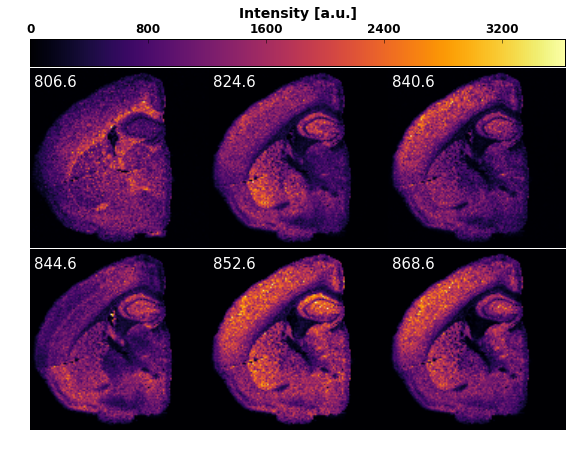

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
mz_range = 0.2
mz_vals = [806.6, 824.6, 840.6, 844.6, 852.6, 868.6]
mz_selections = [np.where((mz_data>(mzi-mz_range)) == (mz_data<(mzi+mz_range)))[0] 
                for mzi in mz_vals]
ncols = 3
nrows = int(np.ceil(len(mz_vals) / float(ncols)))
colormap = 'inferno'

fig = plt.figure(1, (10., 7.))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                nrows_ncols = (nrows, ncols), # creates 2x2 grid of axes
                axes_pad=0.02, # pad between axes in inch.
                cbar_location = "top",
                    cbar_mode="single")

for i in range(len(mz_vals)):
    mz_select = mz_selections[i]
    img = msi_data[...,mz_select].max(axis=2)
    f = grid[i].imshow(img,cmap=colormap)
    grid[i].axis('off')
    grid[i].text(2, 12, str(mz_vals[i]), color='white', size=15)
    
cbar = grid.cbar_axes[0].colorbar(f)
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(12)
    t.set_fontweight('bold')
cbar.set_label_text("Intensity [a.u.]",fontsize=14,color='black',weight='bold')

if save_images:
    plt.savefig("imr_omsi_intensity_maps.pdf")

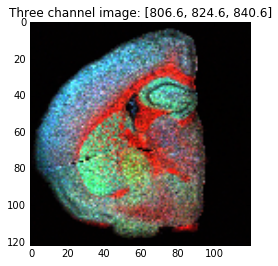

In [5]:
temp_image = []
for i in range(3):
    ims = msi_data[...,mz_selections[i]].max(axis=2)
    p98 = np.percentile(ims, (99))
    ims = np.clip(ims /  float(p98), 0, 1)
    temp_image.append(ims)
three_channel_image = np.stack(temp_image, axis=2)
plt.imshow(three_channel_image)
plt.title("Three channel image: " + str(mz_vals[0:3]))
if save_images:
    plt.savefig("imr_omsi_three_channel_msi.pdf")
plt.show()

## Create a scaled, gray-scale image from the MSI data

In [6]:
def msi_to_monochrome(indata, scale_factor, interp):
    """
    Create upsampled monochrome image from the MSI image
    """
    n_components = 10
    peak_cube_flat = np.array([np.array(peak_cube[:, :, i]).flatten() for i in range(peak_cube.shape[2])]).T
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(peak_cube_flat.astype(float))
    peak_cube_pca_flat = pca.transform(peak_cube_flat)
    peak_cube_monochrome = peak_cube_pca_flat.reshape((peak_cube.shape[0], peak_cube.shape[1], n_components))[:, :, 0]
    scaled_monochrome_image = scipy.misc.imresize(peak_cube_monochrome, size=scale_factor, interp=interp)
    return scaled_monochrome_image, pca.explained_variance_ratio_
    
peak_cube = msi_file['/entry_0/analysis_0/peak_cube'][:]
scale_factor = 500
interp = 'cubic'
msi_monochrome, explained_variances = msi_to_monochrome(peak_cube, scale_factor, interp)

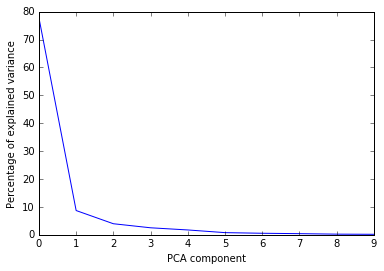

In [7]:
plt.plot(explained_variances * 100)
plt.xlabel("PCA component")
plt.ylabel("Percentage of explained variance")
if save_images:
    plt.savefig("imr_omsi_pca_peak_cube.pdf")
plt.show()

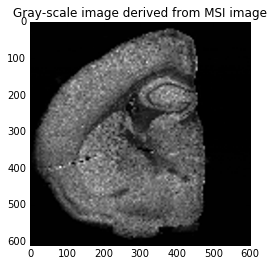

In [8]:
plt.imshow(msi_monochrome, cmap=cm.Greys_r)
plt.title("Gray-scale image derived from MSI image")
if save_images:
    plt.savefig("imr_omsi_gray_scale.pdf")
plt.show()

# Create the example HDF5 data file
## Select the test data

In [9]:
# Full MSI dataset
elec_image_msi = msi_data
# In the example we'll map from the MSI image to this up-sampled gray-scale version of the image
elec_image = msi_monochrome
# Print the shapes of the images for validation
print "Source MSI image shape:        " + str(elec_image_msi.shape)
print "Target gray-scale image shape: " + str(elec_image.shape)

Source MSI image shape:        (122, 120, 80339)
Target gray-scale image shape: (610, 600)


## Create a test HDF5 file

In [10]:
# Create the test HDF5 file
tempfile = NamedTemporaryFile()
test_file = h5py.File(tempfile.name, 'a')

# Write both datasets to file
test_file['image1'] = elec_image
test_file['image2'] = elec_image_msi
image1 = test_file['image1'] 
image2 = test_file['image2'] 

## Validated the file:  Plot the example images from file 

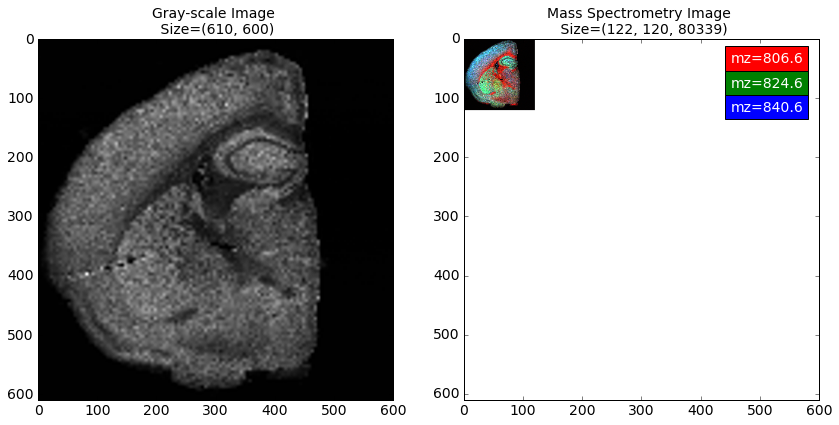

In [11]:
plt.rcParams['figure.figsize'] = (14.0, 14.0)
label_size = 14

#Plot the grayscale image
plt.subplot(1, 2, 1)
plt.imshow(image1[:], cmap='gray')
plt.title("Gray-scale Image \n Size="+str(image1.shape), size = label_size)
#plt.xlabel('Pixel index X', size=label_size)
#plt.ylabel('Pixel index Y', size=label_size)
plt.tick_params(axis='both', which='major', labelsize=label_size)

#Plot the MSI image
plt.subplot(1, 2, 2)
temp_image = []
for i in range(3):
    ims = image2[...,mz_selections[i]].max(axis=2)
    p98 = np.percentile(ims, (99))
    ims = np.clip(ims /  float(p98), 0, 1)
    temp_image.append(ims)
three_channel_image = np.stack(temp_image, axis=2)
plt.imshow(three_channel_image)
plt.title("Mass Spectrometry Image \n Size="+str(image2.shape), size = label_size)

plt.text(450, 40, "mz=" + str(mz_vals[0]), style='normal',
             bbox={'facecolor':'red', 'alpha':1, 'pad':5}, color='white', size=label_size)
plt.text(450, 82, "mz=" + str(mz_vals[1]), style='normal',
             bbox={'facecolor':'green', 'alpha':1, 'pad':5}, color='white', size=label_size)
plt.text(450, 122, "mz=" + str(mz_vals[2]), style='normal',
         bbox={'facecolor':'blue', 'alpha':1, 'pad':5}, color='white', size=label_size)

plt.tick_params(axis='both', which='major', labelsize=label_size)
plt.xlim(0, image1.shape[1])
plt.ylim(image1.shape[0], 0)
#plt.xlabel('Pixel index X', size=label_size)
#plt.ylabel('Pixel index Y', size=label_size)
if save_images:
    plt.savefig("imr_omsi_gray_scale_vs_MSI.pdf")
plt.show()

# Create the index map relationship
## Create the mapping between the images

Compute a map from the low-res version image2 to the full-res version image1

In [12]:
# Initalize the array for our map
image_map = np.zeros(shape=(elec_image_msi.shape[0], 
                            elec_image_msi.shape[1],
                            2,     # Each index has two components (x,y)
                            25),   # Each pixel in image2 corresponds to 25 pixel in image1
                     dtype='uint16')

# Fill the map with the pixel correspondences
for xi in range(image_map.shape[0]):
    for yi in range(image_map.shape[1]):
        image_map[xi, yi, 0, :] = np.resize(np.arange(xi*5, xi*5+5), 25)
        image_map[xi, yi, 1, 0:5  ] = yi*5
        image_map[xi, yi, 1, 5:10 ] = yi*5 + 1
        image_map[xi, yi, 1, 10:15] = yi*5 + 2
        image_map[xi, yi, 1, 15:20] = yi*5 + 3
        image_map[xi, yi, 1, 20:25] = yi*5 + 4
# Save the map data to file
test_file['image_map'] = image_map
image_map_h5 = test_file['image_map'] 

# Create optional user data documenting how the image2 
# was generated from image1
user_description = "Optical image derived from MSI image"
user_properties = {'algorithm': 'msi_to_monochrome',
                   'parameters': {'indata': '/entry_0/analysis_0/peak_cube',
                                  'scale_factor': 500,
                                  'interp': 'cubic'}}

## Create the relationship between the images

In [13]:
# Create the index map relationship
mapping_relationship = RelationshipAttribute.create_index_map_relationship(
    name='monochrome image',               # Name of the relationship
    map_object=image_map_h5,            # Index map
    source_object=image2,               # Source object of the relationship
    target_object=image1,               # Target object of the relationship
    map_indexing_axis=2,                # Axis in the map with index components
    map_stack_axis=3,                   # Axis in the map with the index list
    source_axis=[0,1],                  # Axes in the source to which the relationship applies
    target_axis=[0,1],                  # Axes in the target to which the relationship applies
    user_description=user_description,  # Optional user description of the relationship
    user_properties=user_properties)    # Optional user properties describing the relationship

# Using the Relationship

Getting all relationships that define the index map relationship is simple:

In [14]:
imr = RelationshipAttribute.get_index_map_relationship(image2, 'monochrome image') 
# Alternatively, we could have here naturally also just used the mapping_relationship 
# which were returned to us when we created the relationships,

Using the index map relationship we can now easily retrieve all the datasets involved in our relationships:

In [15]:
imr_source = imr['MAP_TO_SOURCE'].target
imr_target = imr['MAP_TO_TARGET'].target
imr_map = imr['MAP_TO_SOURCE'].source

Now that we have our datasets, lets see how we can load a single pixel in our source image as well as the corresponding pixels in our target image. 

In [16]:
# Creating a selection so that we can easily reuse it
imr_select = np.s_[36, 70] #np.s_[47,98]
# Loading the selected pixel from the source (i.e., image2)
source_data = imr_source[imr_select]
# Mapping the selection to the target (i.e., image1)
imr_select_target = imr['MAP_TO_TARGET'][imr_select]
# Loading the corresponding pixels from the target dataset
target_data = imr_target[:][imr_select_target[0,:], imr_select_target[1,:]] 

As we can see, using relationships greatly simplifies the collaborative use of data. We were able to easily load data from our two images and we didn't even need to know the datasets nor what the mapping between our datasets was. 

Now that we have loaded all our data, let's plot it to see what is going on:

Source data: 
[10 16 10 ...,  0  0  0]
Target data: 
[[ 77  90 100 105 108]
 [ 89 106 117 120 119]
 [ 99 119 131 133 128]
 [107 128 141 142 136]
 [113 136 149 150 144]]
X target index
[180 181 182 183 184 180 181 182 183 184 180 181 182 183 184 180 181 182
 183 184 180 181 182 183 184]
Y target index
[350 350 350 350 350 351 351 351 351 351 352 352 352 352 352 353 353 353
 353 353 354 354 354 354 354]


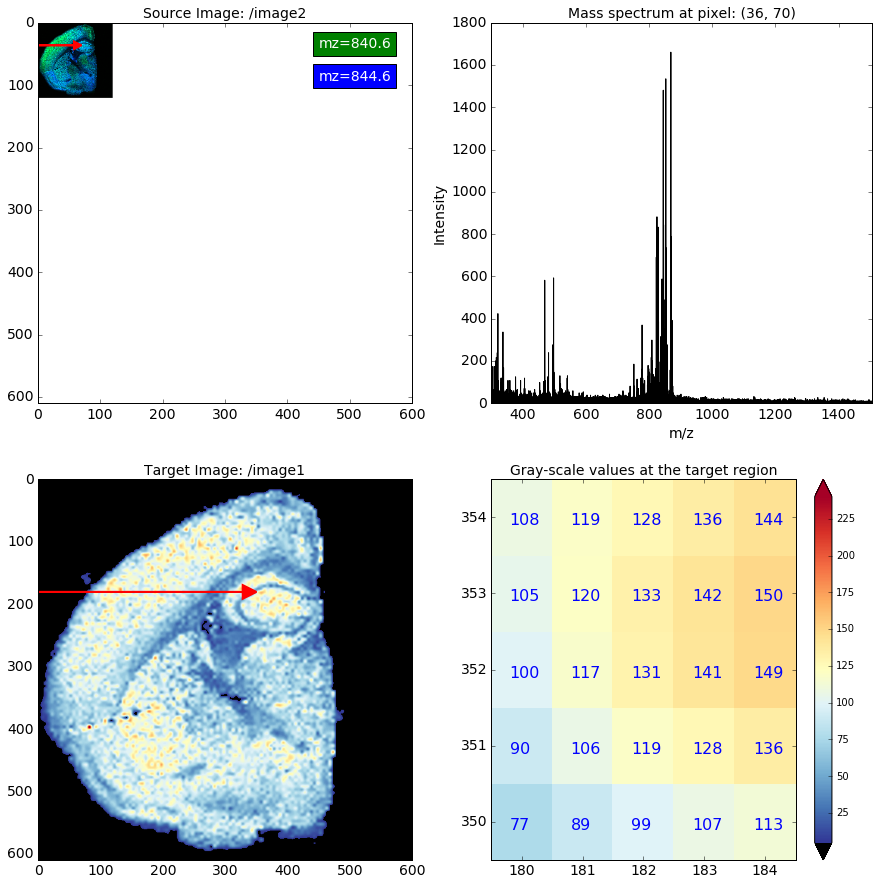

In [17]:
##############################################
#  Plotting setting                        #
##############################################
cmap = 'gray'
arrow_color = 'red'
arrow_linewidth = 2
fig = plt.figure(figsize=(15,15))
twochannel_msi_plot = True
title_size = 14
x_lable_size = 14
y_lable_size = 14
tick_size = 14

##############################################
#  Source images (MSI)(top row)              #
##############################################
# Plot the source image
plt.subplot(2, 2, 1)
if not twochannel_msi_plot:
    g = plt.imshow(imr_source[:,:,mz_selections[1]].max(axis=2), cmap=cmap) 
    plt.title('Source Image: ' + imr_source.name, size=title_size)
    plt.text(450, 40, "mz=" + str(mz_vals[1]), style='normal',
             bbox={'facecolor':'gray', 'alpha':1, 'pad':5}, color='white', size=title_size)
else:
    temp_image = []
    temp_image.append(np.zeros(image2.shape[0]*image2.shape[1]).reshape(image2.shape[0], image2.shape[1]))
    for i in range(2):
        ims = image2[...,mz_selections[i+2]].max(axis=2)
        p98 = np.percentile(ims, (99))
        ims = np.clip(ims /  float(p98), 0, 1)
        temp_image.append(ims)
    two_channel_image = np.stack(temp_image, axis=2)
    g = plt.imshow(two_channel_image)
    plt.title('Source Image: ' + imr_source.name,  size=title_size)
    plt.text(450, 40, "mz=" + str(mz_vals[2]), style='normal',
             bbox={'facecolor':'green', 'alpha':1, 'pad':5}, color='white', size=title_size)
    plt.text(450, 92, "mz=" + str(mz_vals[3]), style='normal',
             bbox={'facecolor':'blue', 'alpha':1, 'pad':5}, color='white', size=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)

# Draw an arrow pointing to the selected pixel
head_size = 12
g.axes.arrow(0, 
             imr_select[0], 
             imr_select[1]-head_size, 
             0, 
             head_width=head_size, 
             head_length=head_size, 
             linewidth=arrow_linewidth,
             color=arrow_color)
# Set the x/y limits of the plot for direct comparison
plt.xlim(0, imr_target.shape[1])
plt.ylim(imr_target.shape[0], 0)
#plt.xlabel('Pixel index X', size=x_lable_size)
#plt.ylabel('Pixel index Y', size=y_lable_size)

# Draw a plot of our selected pixel
plt.subplot(2, 2, 2)
plt.plot(mz_data, source_data, color='black')
plt.xlim(mz_data.min(), mz_data.max())
plt.title('Mass spectrum at pixel: ' + str(imr_select), size=title_size)
plt.xlabel("m/z", size=x_lable_size)
plt.ylabel("Intensity", size=y_lable_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)


##############################################
#  Target images (gray-scale)(bottom row)    #
##############################################
# Draw plot of our target image
vmin = 5
vmax = 240
cmap = 'RdYlBu_r' # 'terrain_r'
plt.subplot(2, 2, 3)
g = plt.imshow(imr_target[:], cmap=cmap, vmin=vmin, vmax=vmax)
plt.title('Target Image: ' + imr_target.name, size=title_size)
#plt.xlabel('Pixel index X', size=x_lable_size)
#plt.ylabel('Pixel index Y', size=y_lable_size)
# Draw an arrow pointing to the corresponding pixel
min_y_index = imr_select_target[1,:].min()
min_x_index = imr_select_target[0,:].min()
head_size = 22
g.axes.arrow(0, 
             min_x_index,
             min_y_index-head_size, 
             0, 
             head_width=head_size, 
             head_length=head_size,
             linewidth=arrow_linewidth,
             color=arrow_color)
plt.tick_params(axis='both', which='major', labelsize=tick_size)

# Draw a plot of the selected target pixels
plt.subplot(2, 2, 4)
imgplot = plt.pcolormesh(target_data.reshape(5,5, order='F'), cmap=cmap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(5)+0.5, np.unique(imr_select_target[0,:]))
plt.yticks(np.arange(5)+0.5, np.unique(imr_select_target[1,:]))
#plt.xlabel('Pixel index X', size=x_lable_size)
#plt.ylabel('Pixel index Y', size=y_lable_size)
for i in range(5):
    for j in range(5):
        plt.text(i+0.3, j+0.4, str(target_data.reshape(5,5)[i,j]), size=16, color='blue')
plt.title('Gray-scale values at the target region', size=title_size)
plt.tick_params(axis='both', which='major', labelsize=tick_size)
a = plt.colorbar(imgplot, extend='both')
a.get_cmap().set_under('black')


        
        
print "Source data: " 
print source_data
print "Target data: " 
print target_data.reshape(5,5)
print "X target index"
print imr_select_target[0,:]
print "Y target index"
print imr_select_target[1,:]

if save_images:
    plt.savefig("imr_omsi_source_target_selection.pdf")
plt.show()

As we can see, we selected a single pixel in the source image, which corresponds a `5x5` subimage (i.e., 25 pixels) in the target image. Since we used `nearest` neightbor interpolation when resizing the image, we see that the value of the source pixel matches the value of the top-left pixel in our target image (i.e., the selected target pixel with the smallest `x` and `y` index). The blue lines we added to the image, furthermore, confirm that we correctly selected the correct region in target based on the selection in our source.

## Additional Plots for Validation

### Specification of the Relationships that Define our Index Map Relationship

In [18]:
print "image2 ---> order ---> image_map"
print imr['SOURCE_TO_MAP'].relationship_spec.to_json(True)
print ""
print "image_map ---> indexes ---> image1"
print imr['MAP_TO_TARGET'].relationship_spec.to_json(True)
print ""
print "image_map ---> order ---> image2"
print imr['SOURCE_TO_MAP'].relationship_spec.to_json(True)
print ""
print "image2 ---> user ---> image1  (optional)"
if imr['SOURCE_TO_TARGET'] is not None:
    print imr['SOURCE_TO_TARGET'].relationship_spec.to_json(True)
else:
    print "Not set"

image2 ---> order ---> image_map
{
    "attribute": "monochrome image_IMR_SOURCE_TO_MAP",
    "axis": [
        0,
        1
    ],
    "description": "The target of this relationship defined a mapfrom the source of this relationship to/image1",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "order",
    "target": {
        "axis": [
            0,
            1
        ],
        "dataset": "image_map",
        "filename": null,
        "global_path": null,
        "group": null,
        "prefix": null,
        "prefix_all": null
    }
}

image_map ---> indexes ---> image1
{
    "attribute": "monochrome image_IMR_MAP_TO_TARGET",
    "axis": {
        "INDEXING_AXIS": 2,
        "STACK_AXIS": 3
    },
    "description": "The source defines a map from /image2to the target of this relationship",
    "optional": false,
    "prefix": null,
    "properties": null,
    "relationship_type": "indexes",
    "target": {
        "axis": [
            0